Looking deeper into preferences, does separating by beer style reveal a style specific bias, or do people remain globally biased? (for states that don't have sig diff, can do style analysis to see if there is)

First, we look at which beer styles are prefered for each state users

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import LogNorm

In [68]:
BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')

In [69]:
print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]


(8393032, 15)
(7892754, 15)


In [70]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')] #remove lines where there is no specific state in user_state or beer_state
print(US_ratings.shape)


(6331638, 15)


In [86]:
state_style_stats = US_ratings.groupby(['user_state', 'style']).agg(average_rating=('rating', 'mean'),nb_ratings=('rating', 'size')).reset_index() #calculating the number of ratings and average ratings per state per beer style
print(state_style_stats)

     user_state                       style  average_rating  nb_ratings
0       Alabama                     Altbier        3.579111          90
1       Alabama      American Adjunct Lager        2.663220         354
2       Alabama    American Amber / Red Ale        3.693687        1112
3       Alabama  American Amber / Red Lager        3.278421         323
4       Alabama         American Barleywine        4.001337         344
...         ...                         ...             ...         ...
5043    Wyoming                Vienna Lager        3.638400          50
5044    Wyoming                  Weizenbock        4.063333          21
5045    Wyoming                   Wheatwine        3.803043          23
5046    Wyoming               Winter Warmer        3.692045          88
5047    Wyoming                     Witbier        3.517923         130

[5048 rows x 4 columns]


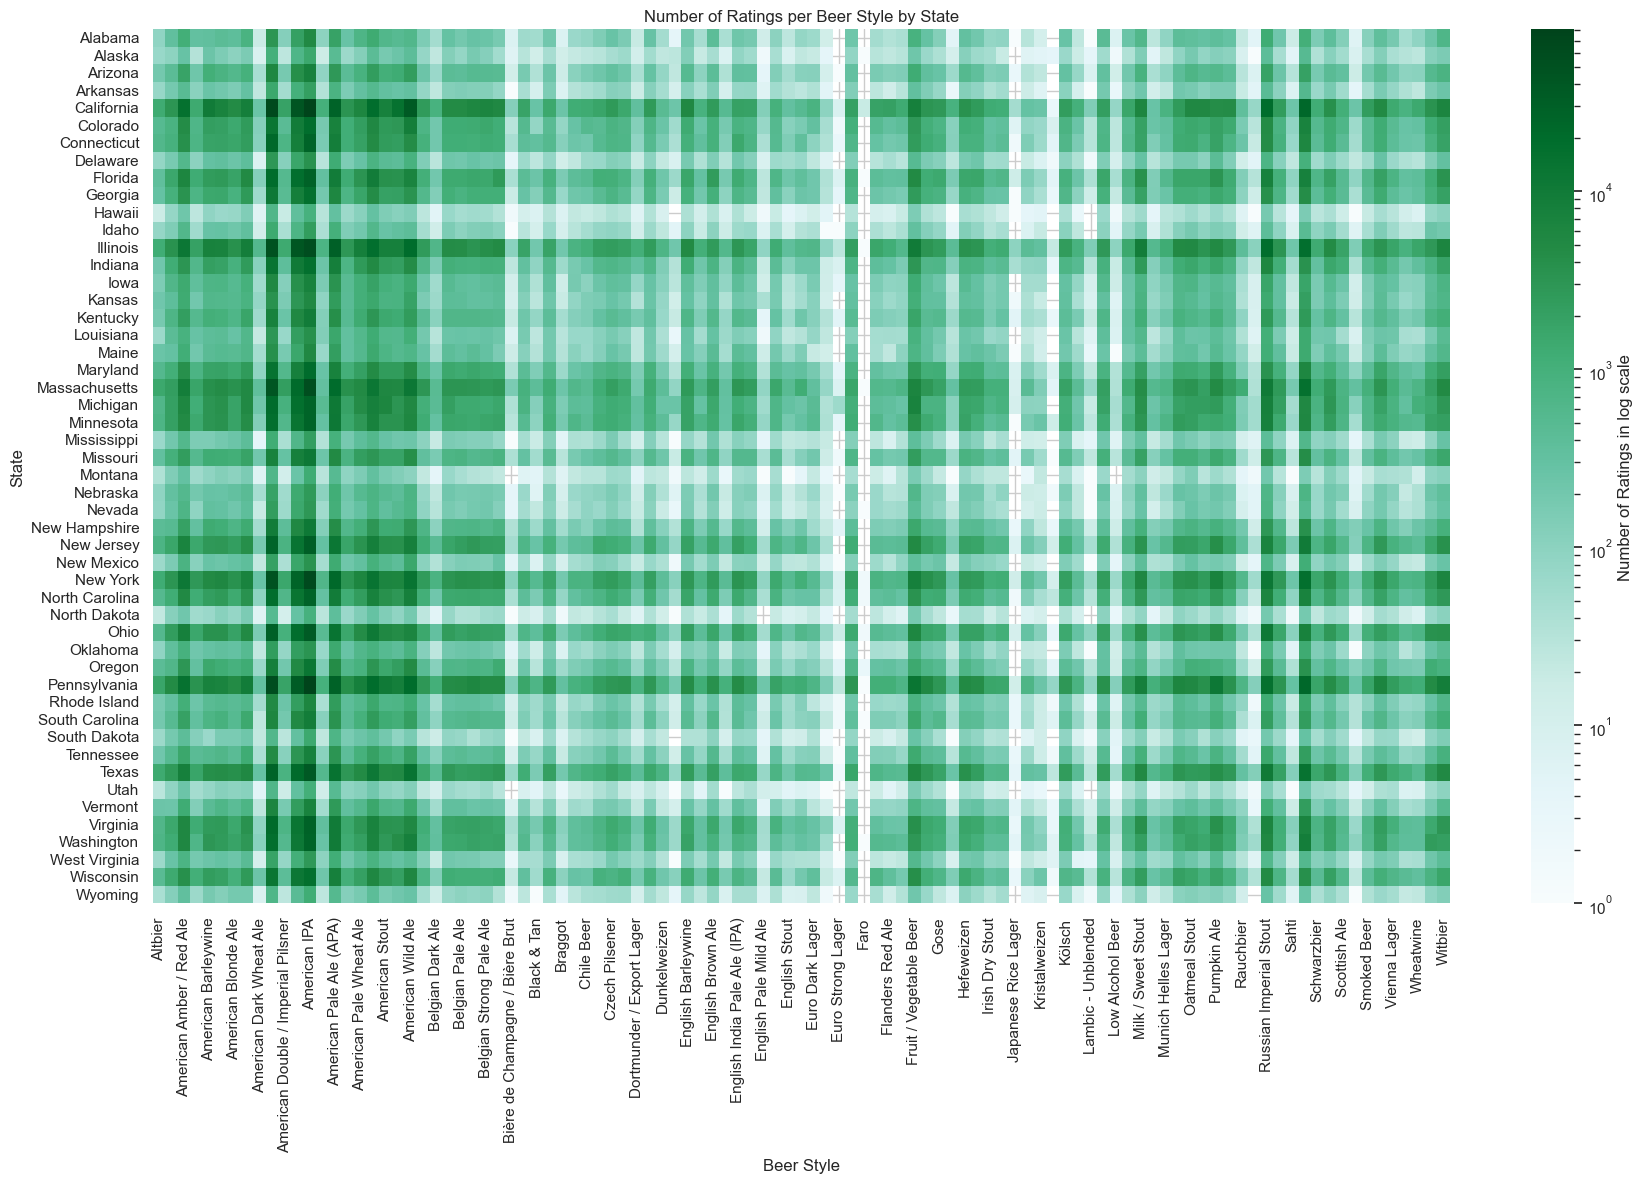

In [ ]:
# heatmap to visualize in log scale in order to be more representative
state_style_nb_ratings_table = state_style_stats.pivot_table(index='user_state', columns='style', values='nb_ratings', fill_value=0)

plt.figure(figsize=(18, 12))
sns.heatmap(state_style_nb_ratings_table, cmap='BuGn', annot=False, norm=LogNorm(), cbar_kws={'label': 'Number of Ratings in log scale'})
plt.xlabel('Beer Style')
plt.ylabel('State')
plt.title('Number of Ratings per Beer Style by State')
plt.xticks(rotation=90)  #for readability
plt.tight_layout()
plt.show()


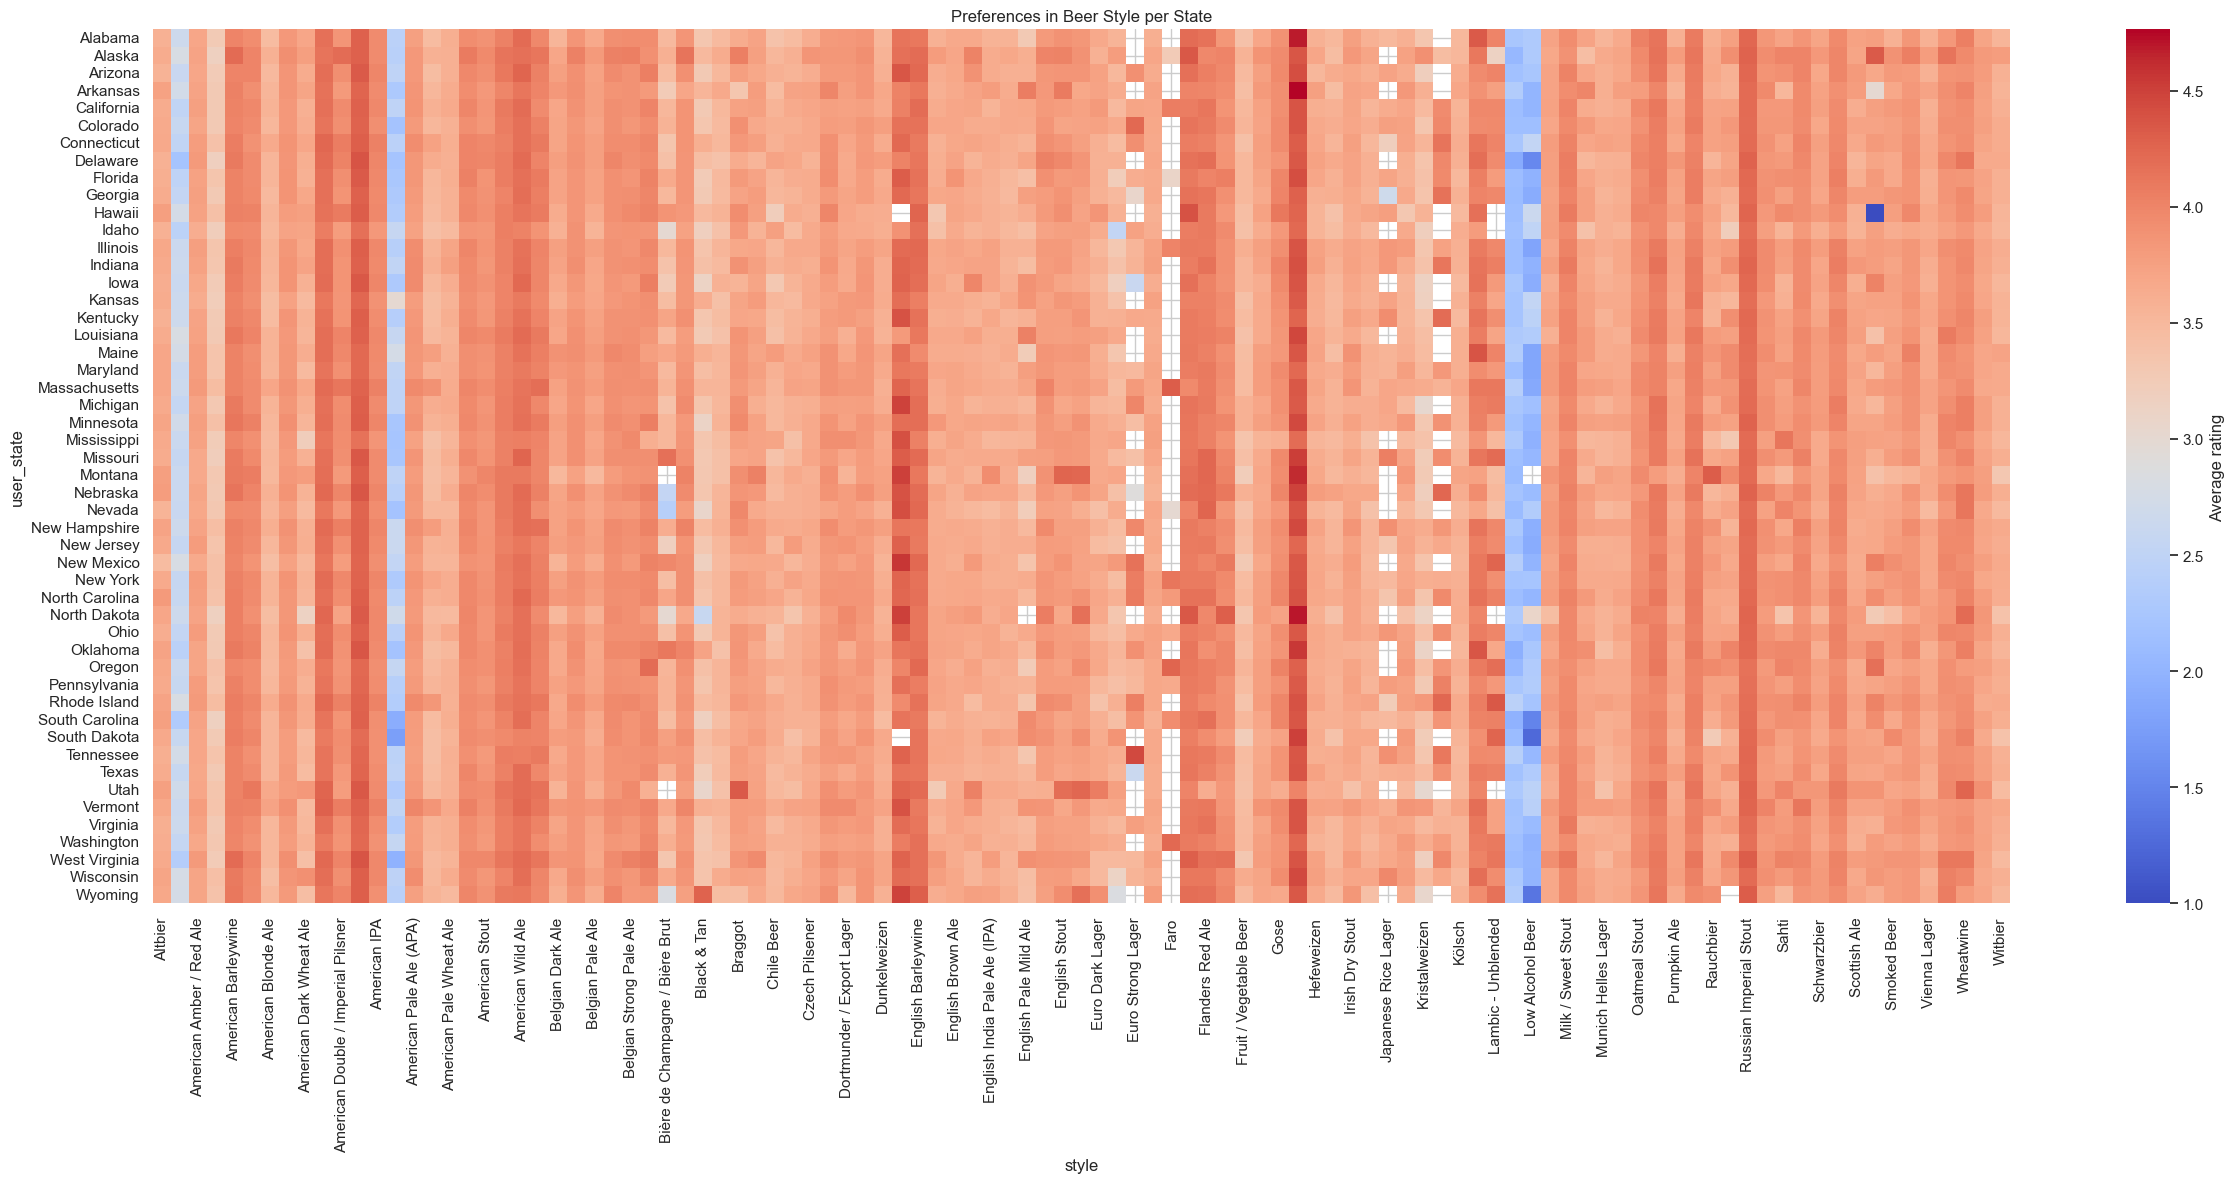

In [ ]:
# table with all average beer ratings per style for each state
state_style_average_rating_table = state_style_stats.pivot_table(index='user_state', columns='style', values='average_rating')

# heatmap to vizualise preferences in beer style per state
plt.figure(figsize=(25, 12))
sns.heatmap(state_style_average_rating_table, annot=False, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Average rating'})
plt.xticks(rotation=90)
plt.title('Preferences in Beer Style per State')
plt.tight_layout()
plt.show()

We need to take in account both the number of ratings and the maximum rating per style per state, because for example if a style has only one high rating it is not very relevant. therefor we define the weight as the multiplication of the average rating and number of rating per style and state.

C:\Users\helen\AppData\Local\Temp\ipykernel_27568\930055799.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)


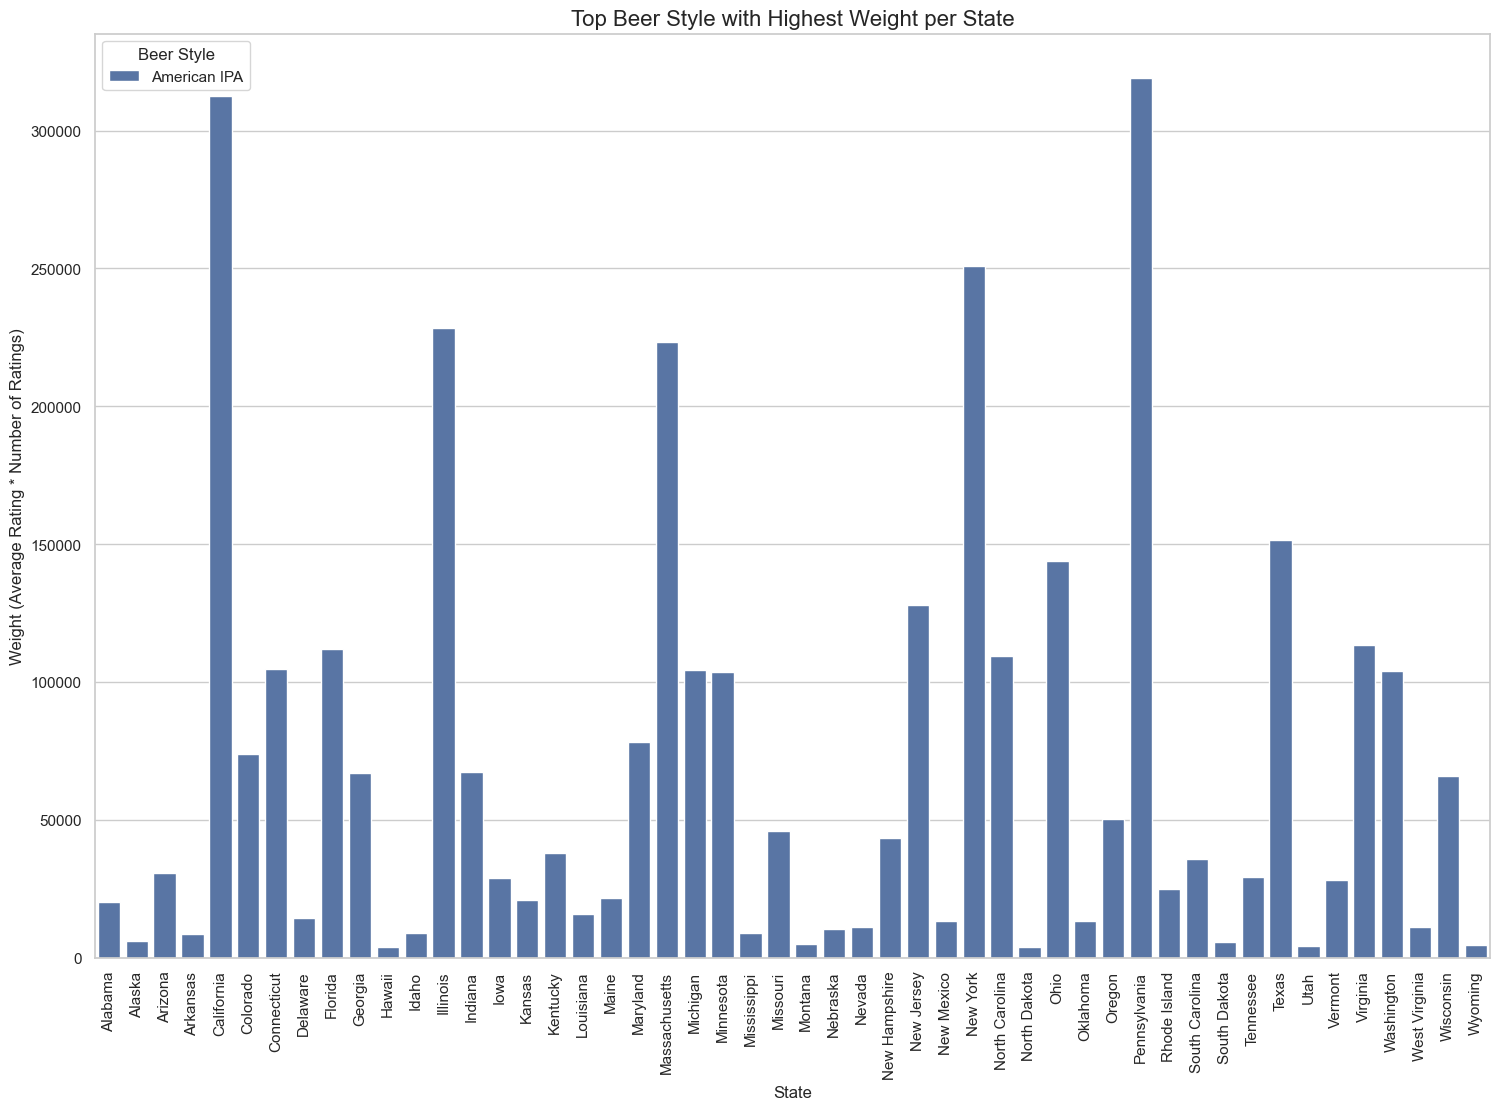

        user_state         style     weight
0          Alabama  American IPA   20175.45
1           Alaska  American IPA    5924.35
2          Arizona  American IPA   30753.18
3         Arkansas  American IPA    8434.31
4       California  American IPA  312655.26
5         Colorado  American IPA   73759.44
6      Connecticut  American IPA  104614.82
7         Delaware  American IPA   14160.93
8          Florida  American IPA  111876.99
9          Georgia  American IPA   67119.94
10          Hawaii  American IPA    3676.58
11           Idaho  American IPA    8959.49
12        Illinois  American IPA  228407.04
13         Indiana  American IPA   67461.95
14            Iowa  American IPA   28970.84
15          Kansas  American IPA   20841.47
16        Kentucky  American IPA   37870.17
17       Louisiana  American IPA   15618.33
18           Maine  American IPA   21567.44
19        Maryland  American IPA   78329.40
20   Massachusetts  American IPA  223257.64
21        Michigan  American IPA

In [89]:
state_style_stats['weight'] = state_style_stats['average_rating'] * state_style_stats['nb_ratings']

# beer style with maximum weight per state
top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)

plt.figure(figsize=(18, 12))
sns.barplot(data=top_style_per_state, x='user_state', y='weight', hue='style')
plt.title("Top Beer Style with Highest Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.show()

print(top_style_per_state[['user_state', 'style', 'weight']])


We can see that most of the people in every state rate a lot the American IPA beers so even if it is not the style with the highest rating, it is the one which has the highest weight in every state.

C:\Users\helen\AppData\Local\Temp\ipykernel_27568\1884310730.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_2_styles_per_state = state_style_stats.groupby('user_state').apply(


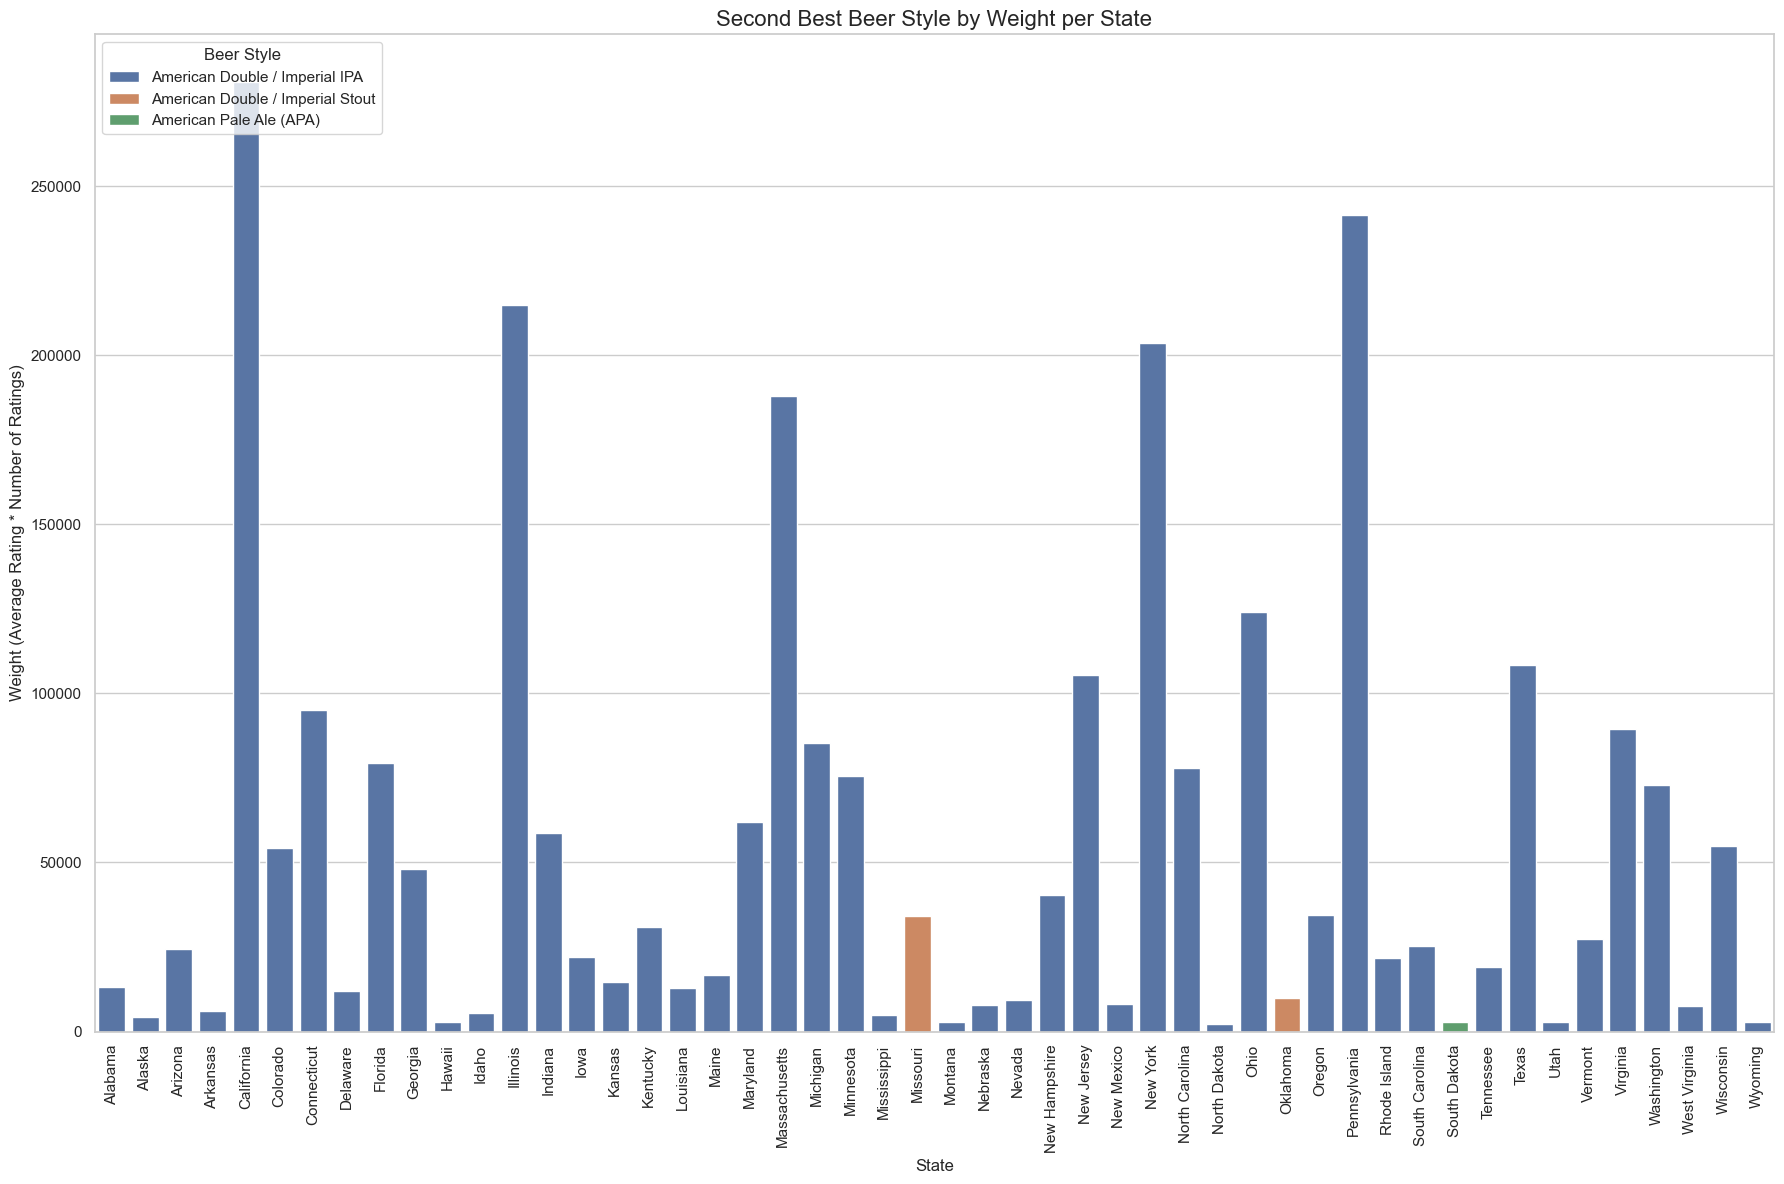

        user_state                             style     weight
0          Alabama    American Double / Imperial IPA   13032.65
1           Alaska    American Double / Imperial IPA    4191.37
2          Arizona    American Double / Imperial IPA   24391.98
3         Arkansas    American Double / Imperial IPA    6106.70
4       California    American Double / Imperial IPA  280860.63
5         Colorado    American Double / Imperial IPA   54152.47
6      Connecticut    American Double / Imperial IPA   95175.75
7         Delaware    American Double / Imperial IPA   12008.46
8          Florida    American Double / Imperial IPA   79531.98
9          Georgia    American Double / Imperial IPA   48109.53
10          Hawaii    American Double / Imperial IPA    2705.05
11           Idaho    American Double / Imperial IPA    5473.06
12        Illinois    American Double / Imperial IPA  214776.03
13         Indiana    American Double / Imperial IPA   58682.28
14            Iowa    American Double / 

In [ ]:
# Second best weighted style per state
top_2_styles_per_state = state_style_stats.groupby('user_state').apply(
    lambda x: x.nlargest(2, 'weight')
).reset_index(drop=True)

second_best_styles = top_2_styles_per_state.groupby('user_state').nth(1).reset_index()

plt.figure(figsize=(18, 12))
sns.barplot(data=second_best_styles, x='user_state', y='weight', hue='style')
plt.title("Second Best Beer Style by Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

print(second_best_styles[['user_state', 'style', 'weight']])

C:\Users\helen\AppData\Local\Temp\ipykernel_27568\1934854422.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_styles_per_state = state_style_stats.groupby('user_state').apply(


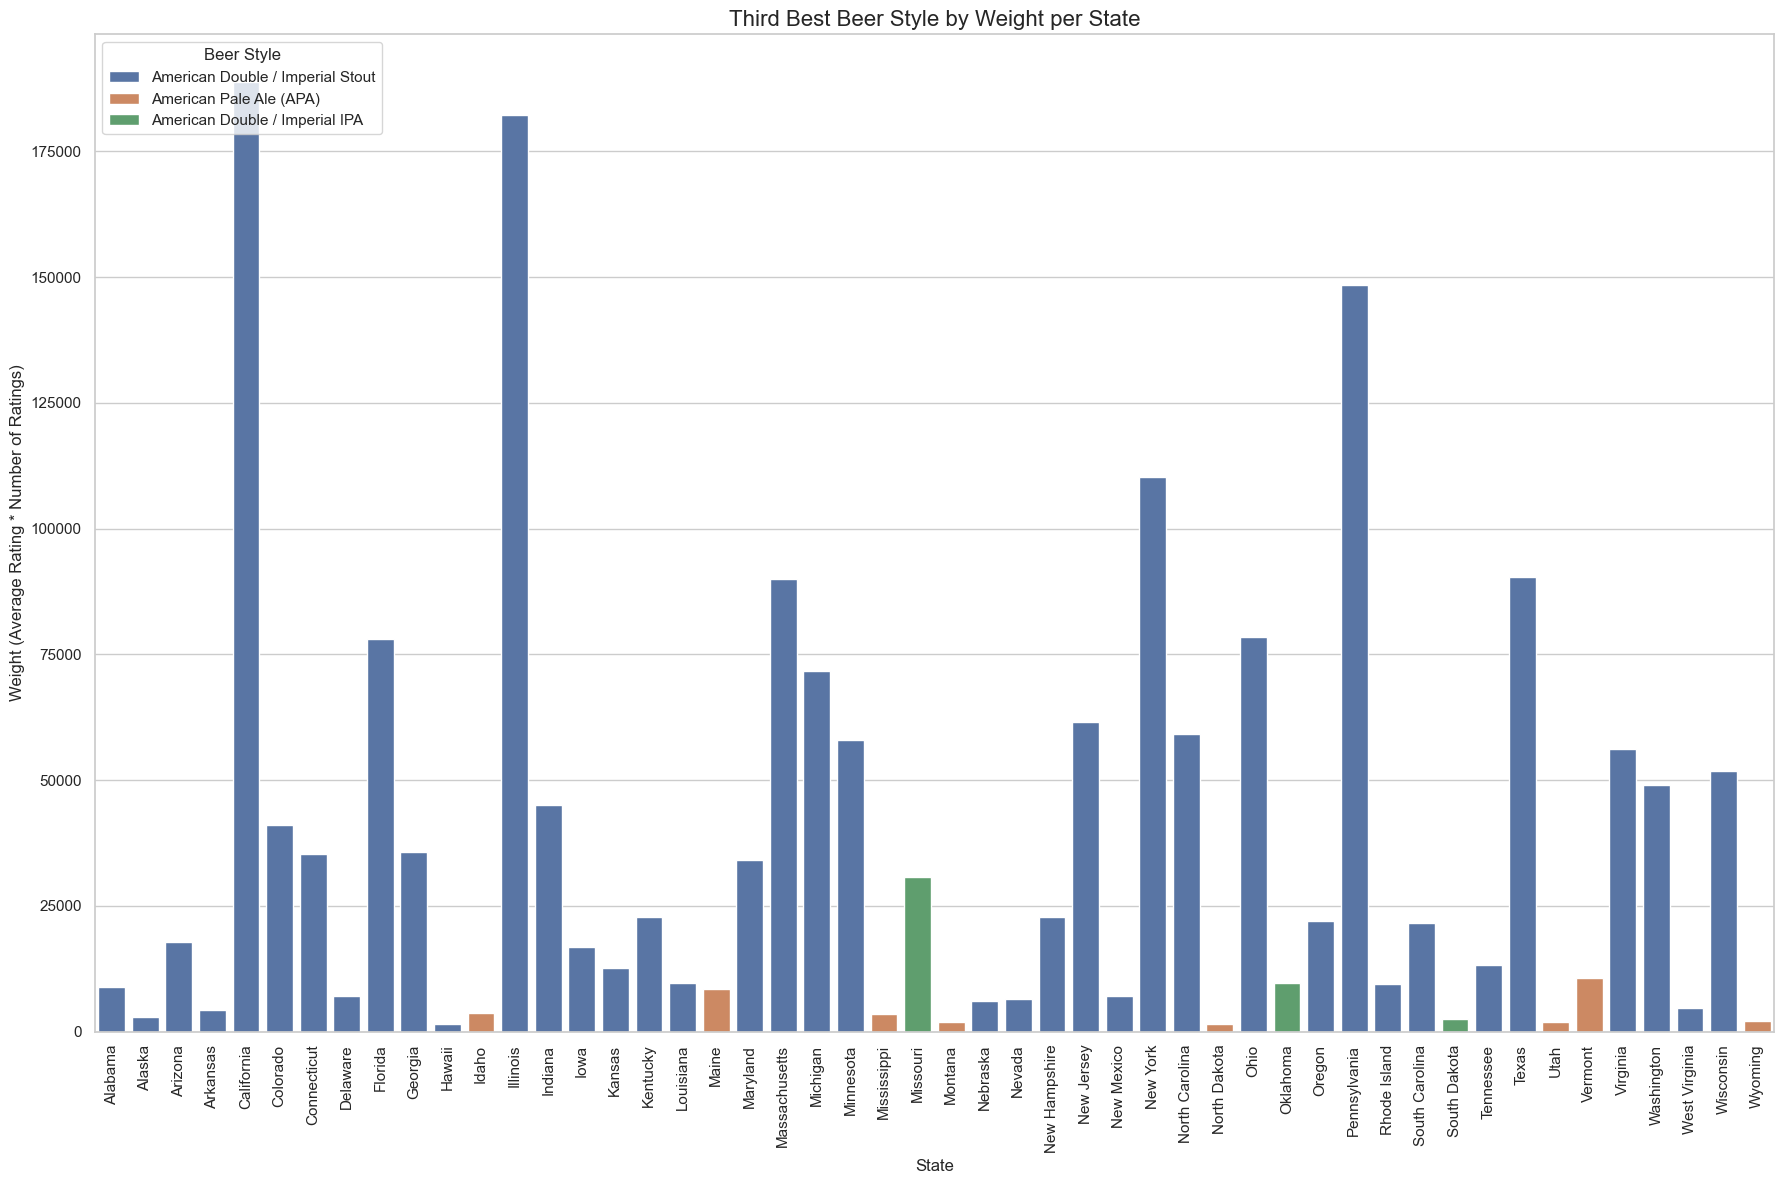

        user_state                             style     weight
0          Alabama  American Double / Imperial Stout    8820.17
1           Alaska  American Double / Imperial Stout    2933.43
2          Arizona  American Double / Imperial Stout   17799.92
3         Arkansas  American Double / Imperial Stout    4350.62
4       California  American Double / Imperial Stout  188786.74
5         Colorado  American Double / Imperial Stout   41095.33
6      Connecticut  American Double / Imperial Stout   35245.20
7         Delaware  American Double / Imperial Stout    7145.44
8          Florida  American Double / Imperial Stout   78076.77
9          Georgia  American Double / Imperial Stout   35653.80
10          Hawaii  American Double / Imperial Stout    1547.23
11           Idaho           American Pale Ale (APA)    3680.67
12        Illinois  American Double / Imperial Stout  182232.00
13         Indiana  American Double / Imperial Stout   44992.87
14            Iowa  American Double / Im

In [ ]:
# Third best weighted style per state
top_3_styles_per_state = state_style_stats.groupby('user_state').apply(
    lambda x: x.nlargest(3, 'weight')
).reset_index(drop=True)

third_best_styles = top_3_styles_per_state.groupby('user_state').nth(2).reset_index()

plt.figure(figsize=(18, 12))
sns.barplot(data=third_best_styles, x='user_state', y='weight', hue='style', dodge=False)
plt.title("Third Best Beer Style by Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

print(third_best_styles[['user_state', 'style', 'weight']])

C:\Users\helen\AppData\Local\Temp\ipykernel_27568\573862132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_state_style_stats['weight'] = (
C:\Users\helen\AppData\Local\Temp\ipykernel_27568\573862132.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_filtered_style_per_state = filtered_state_style_stats.groupby('user_state').apply(


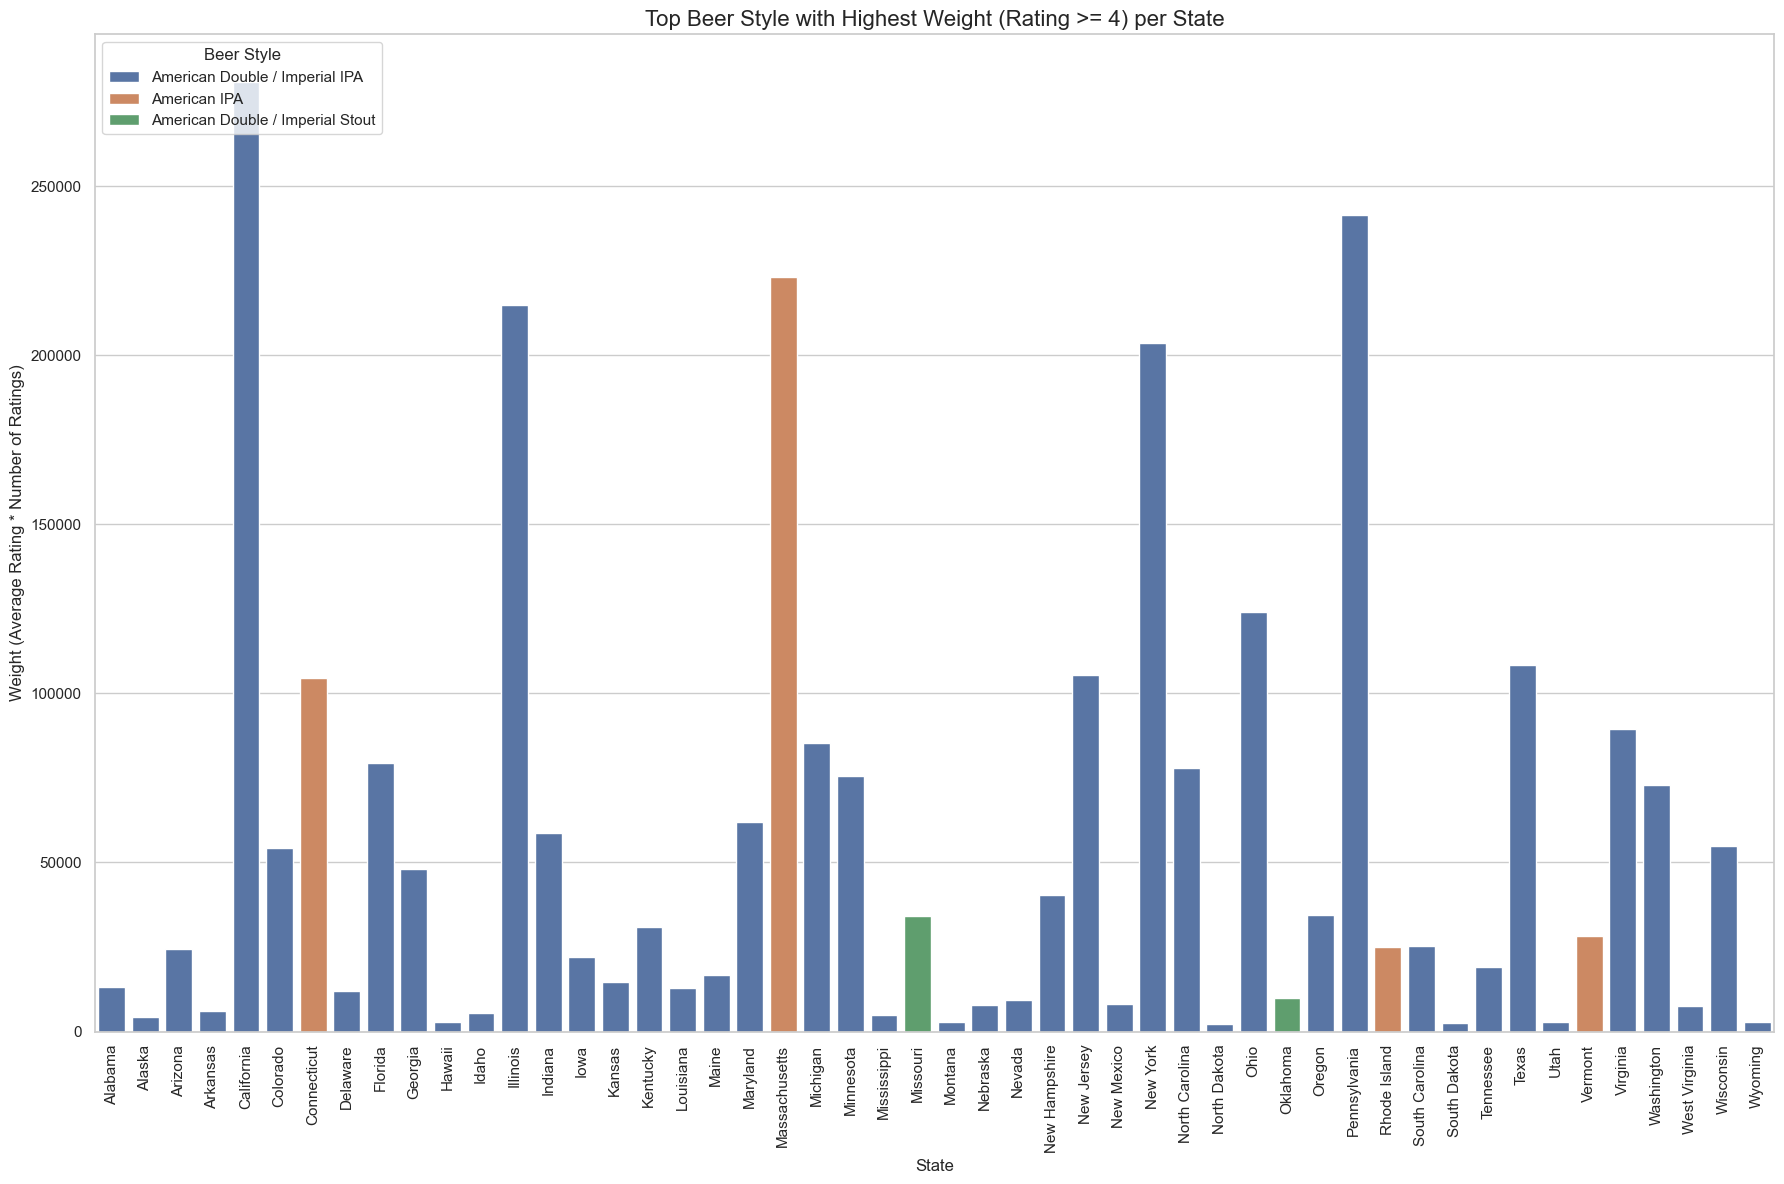

        user_state                             style  average_rating  \
0          Alabama    American Double / Imperial IPA        4.163786   
1           Alaska    American Double / Imperial IPA        4.137581   
2          Arizona    American Double / Imperial IPA        4.185309   
3         Arkansas    American Double / Imperial IPA        4.151394   
4       California    American Double / Imperial IPA        4.161083   
5         Colorado    American Double / Imperial IPA        4.136618   
6      Connecticut                      American IPA        4.033731   
7         Delaware    American Double / Imperial IPA        4.207589   
8          Florida    American Double / Imperial IPA        4.172279   
9          Georgia    American Double / Imperial IPA        4.164967   
10          Hawaii    American Double / Imperial IPA        4.148850   
11           Idaho    American Double / Imperial IPA        4.060134   
12        Illinois    American Double / Imperial IPA        4.18

In [ ]:
## Weights for beer styles with only ratings>=4
filtered_state_style_stats = state_style_stats[state_style_stats['average_rating'] >= 4]

filtered_state_style_stats['weight'] = (filtered_state_style_stats['average_rating'] * filtered_state_style_stats['nb_ratings'])

top_filtered_style_per_state = filtered_state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)

plt.figure(figsize=(18, 12))
sns.barplot(data=top_filtered_style_per_state, x='user_state', y='weight', hue='style', dodge=False)
plt.title("Top Beer Style with Highest Weight (Rating >= 4) per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

print(top_filtered_style_per_state[['user_state', 'style', 'average_rating', 'nb_ratings', 'weight']])

C:\Users\helen\AppData\Local\Temp\ipykernel_27568\3493190074.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_state_style_stats['weight'] = (
C:\Users\helen\AppData\Local\Temp\ipykernel_27568\3493190074.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_filtered_style_per_state = filtered_state_style_stats.groupby('user_state').apply(


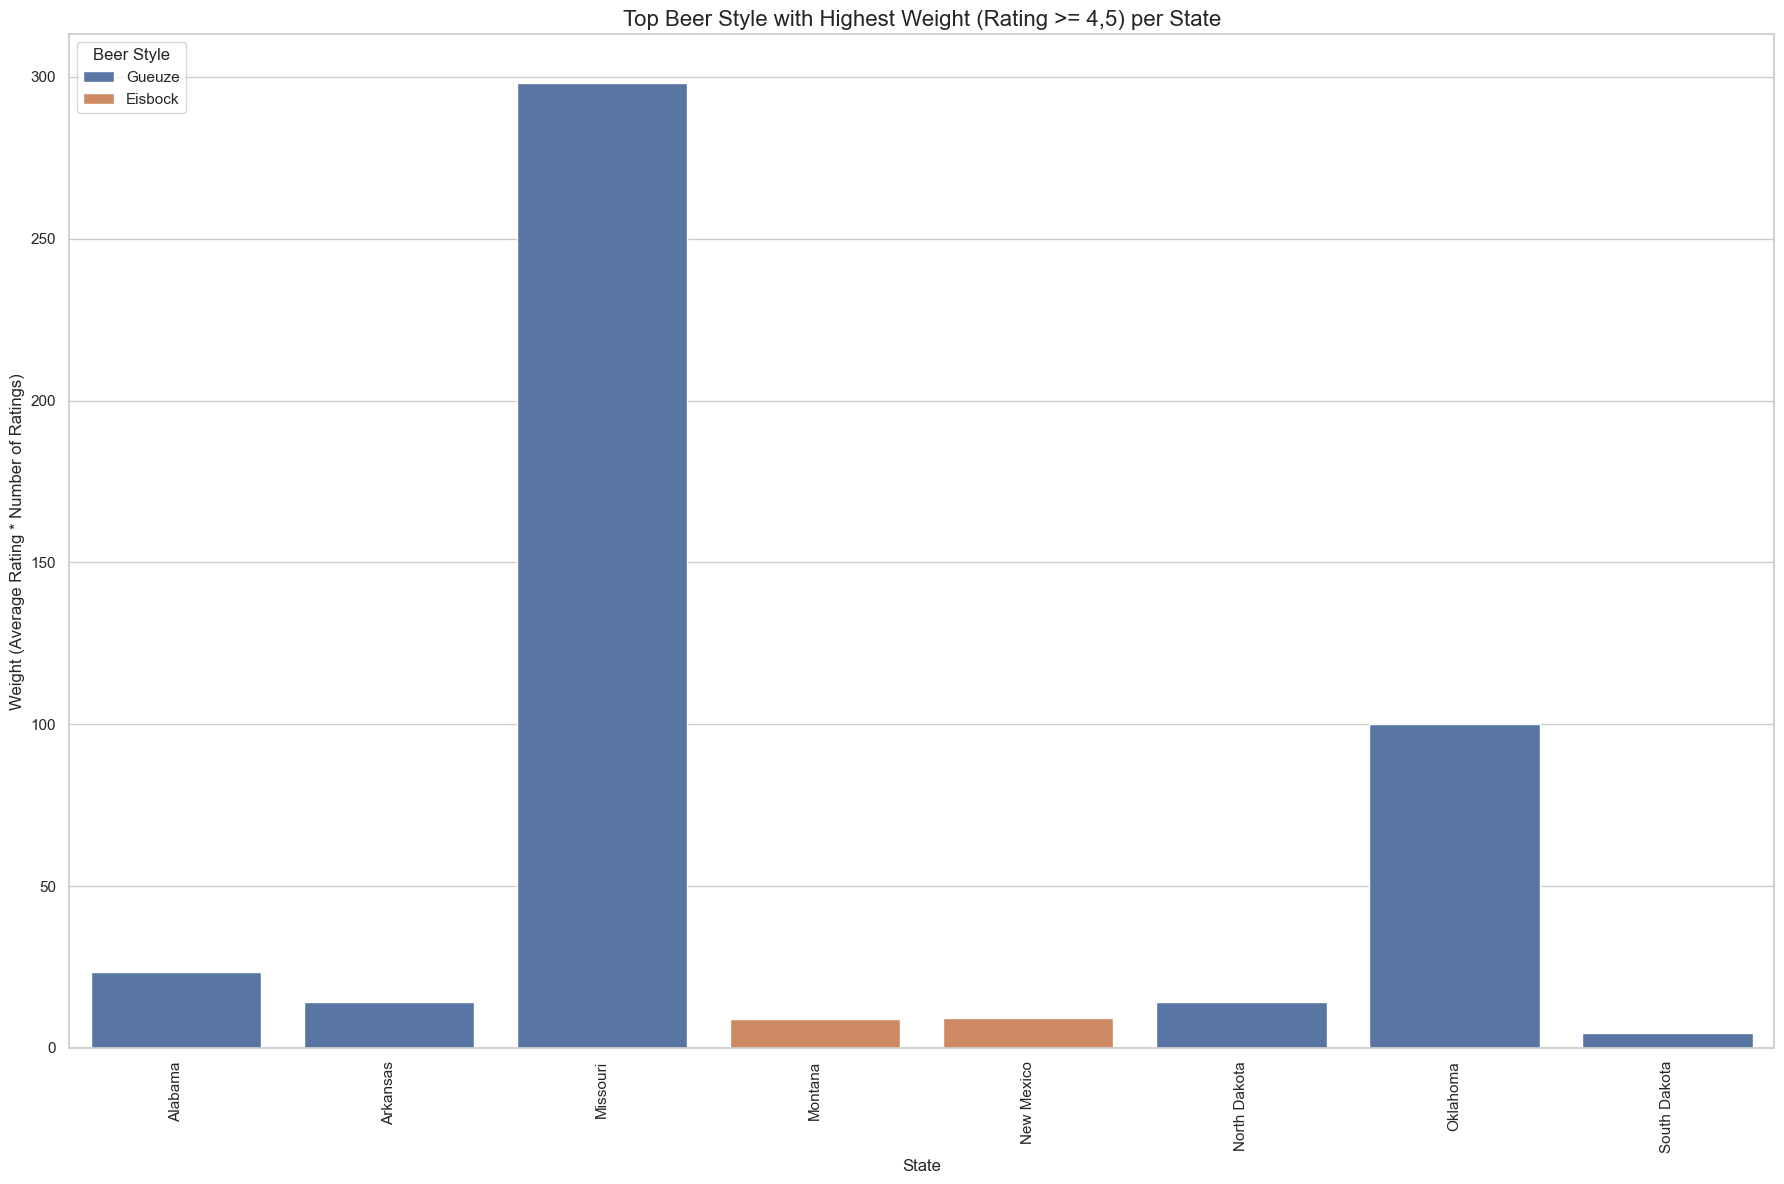

     user_state    style  average_rating  nb_ratings  weight
0       Alabama   Gueuze        4.678000           5   23.39
1      Arkansas   Gueuze        4.763333           3   14.29
2      Missouri   Gueuze        4.518788          66  298.24
3       Montana  Eisbock        4.505000           2    9.01
4    New Mexico  Eisbock        4.565000           2    9.13
5  North Dakota   Gueuze        4.700000           3   14.10
6      Oklahoma   Gueuze        4.550000          22  100.10
7  South Dakota   Gueuze        4.500000           1    4.50


In [ ]:
# Weights for beer styles with only ratings>=4,5
filtered_state_style_stats = state_style_stats[state_style_stats['average_rating'] >= 4.5]

filtered_state_style_stats['weight'] = (filtered_state_style_stats['average_rating'] * filtered_state_style_stats['nb_ratings'])

top_filtered_style_per_state = filtered_state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)

plt.figure(figsize=(18, 12))
sns.barplot(data=top_filtered_style_per_state, x='user_state', y='weight', hue='style', dodge=False)
plt.title("Top Beer Style with Highest Weight (Rating >= 4,5) per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

print(top_filtered_style_per_state[['user_state', 'style', 'average_rating', 'nb_ratings', 'weight']])
